## Part 1: Feature Creation/Extraction

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import os
import shutil
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import warnings
from sklearn.preprocessing import MinMaxScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Get the AReM Data Set

In [2]:
data_folder_path = '../data/AReM/'
files = {}
train_data = {}
test_data = {}

for root, dirs, files_list in os.walk(data_folder_path):
    for file_name in files_list:
        if file_name == '.DS_Store':
            continue
        file_path = os.path.join(root, file_name)
        data = pd.read_csv(file_path, skiprows=4, usecols=[0,1, 2, 3, 4, 5, 6])
        data = data.iloc[:, 1:] 
        files[file_path] = data
#         print(data)

### (b) Splitting Data

In [3]:
data_folder_path = '../data/AReM/'

for root, dirs, files_list in os.walk(data_folder_path):
    for file_name in files_list:
        if file_name == '.DS_Store':
            continue
        file_path = os.path.join(root, file_name)
        
        if (os.path.basename(os.path.dirname(file_path)) in ['bending1', 'bending2'] and 
            file_name in ['dataset1.csv', 'dataset2.csv']) or \
           (os.path.basename(os.path.dirname(file_path)) not in ['bending1', 'bending2'] and 
            file_name in ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']):
            test_data[file_path] = files[file_path]
        else:
            train_data[file_path] = files[file_path]

### (c) Feature Extraction

## Research
Time-domain features that are usually used in time series classification include:

Minimum: The smallest value in the time series.
Maximum: The largest value in the time series.
Mean: The average value of the time series.
Median: The middle value in the sorted time series data.
Standard Deviation: A measure of the spread or dispersion of the time series data.
First Quartile (Q1): The 25th percentile of the data.
Third Quartile (Q3): The 75th percentile of the data.

Some additional features are: 
Correlation Structure: This refers to the relationship between different time series. It can be useful in understanding how one time series affects or is influenced by another.

Distribution: This involves analyzing the probability distribution of the data points within a time series. Understanding the distribution can be crucial for modeling and prediction.

Entropy: Entropy is a measure of disorder or randomness in a time series. It can be used to characterize the complexity of the data.

Stationarity: A time series is considered stationary if its statistical properties (e.g., mean, variance) remain constant over time. Stationarity is an important assumption in many time series models.

Scaling Properties: This refers to how the magnitude of the time series values change over time. Understanding scaling properties can provide insights into trends and patterns in the data.

## ii. Extraction

In [4]:
feature_columns = []
for i in range(1, 7):
    for feature in ['min', 'max', 'mean', 'median', 'std_dev', 'first_quartile', 'third_quartile']:
        feature_columns.append(f"{feature}{i}")

features_df = pd.DataFrame(columns=feature_columns)
train_features_df = pd.DataFrame(columns=feature_columns)
# print(features_df.shape)

def extract_time_domain_features(time_series_data):
    features = {
        'min': np.min(time_series_data),
        'max': np.max(time_series_data),
        'mean': np.mean(time_series_data),
        'median': np.median(time_series_data),
        'std_dev': np.std(time_series_data),
        'first_quartile': np.percentile(time_series_data, 25),
        'third_quartile': np.percentile(time_series_data, 75)
    }
    return features

col_titles = ['avg_rss12', 'var_rss12',  'avg_rss13',  'var_rss13',  'avg_rss23' , 'var_rss23']
for key, value in train_data.items():
    instance_features = []
    for i in col_titles:
#         print(value)
#         print(value[i])
        time_series_data = value[i]
        features = extract_time_domain_features(time_series_data)
#         print(features)
#         print(list(features.values()))
        instance_features.extend(list(features.values()))
#         print(instance_features)
#     print(len(instance_features))
    features_df.loc[len(features_df)] = instance_features
train_features_df = features_df
print("train_features_df",train_features_df)
    
for key, value in test_data.items():
    instance_features = []
    for i in col_titles:
        time_series_data = value[i]
        features = extract_time_domain_features(time_series_data)
        instance_features.extend(list(features.values()))
    features_df.loc[len(features_df)] = instance_features

print(features_df)
# var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23

train_features_df      min1   max1      mean1  median1  std_dev1  first_quartile1  \
0   36.25  48.00  43.969125    44.50  1.616677          43.3100   
1   37.00  48.00  43.454958    43.25  1.384653          42.5000   
2   33.00  47.75  42.179812    43.50  3.666840          39.1500   
3   33.00  45.75  41.678063    41.75  2.241152          41.3300   
4   35.00  47.40  43.954500    44.33  1.557210          43.0000   
..    ...    ...        ...      ...       ...              ...   
64  18.50  44.25  35.752354    36.00  4.609992          33.0000   
65  24.25  45.00  37.177042    36.25  3.577569          34.5000   
66  23.33  43.50  36.244083    36.75  3.818032          33.4575   
67  26.25  44.25  36.957458    36.29  3.431283          34.5000   
68  27.75  44.67  37.144833    36.33  3.754986          34.0000   

    third_quartile1  min2   max2     mean2  ...  std_dev5  first_quartile5  \
0             44.67   0.0   1.50  0.413125  ...  3.314843          20.5000   
1             45.00  

## iii. Standard Deviation

In [5]:
std_deviations = features_df.std()
conf_intervals = {}

print("STANDARD DEVIATION VALUES:")
print(std_deviations)

for feature in std_deviations.index:
    data = features_df[feature].values
    bootstrapped_std = []

    for _ in range(10000): 
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_std.append(np.std(bootstrap_sample))

    lower_bound = np.percentile(bootstrapped_std, 100*0.1/2)
    upper_bound = np.percentile(bootstrapped_std, 100*(1-0.1/2))

    conf_intervals[feature] = (lower_bound, upper_bound)
    
# print(conf_intervals)
# Print the confidence intervals
print("\n90% bootsrap confidence interval for the standard deviation of each feature: \n")
for feature, interval in conf_intervals.items():
    print("\nFor Feature:", feature)
    print("90% Bootstrap Confidence Interval:", interval)


STANDARD DEVIATION VALUES:
min1               9.569975
max1               4.394362
mean1              5.335718
median1            5.440054
std_dev1           1.770306
first_quartile1    6.153590
third_quartile1    5.138925
min2               0.000000
max2               5.062729
mean2              1.574164
median2            1.412244
std_dev2           0.883184
first_quartile2    0.946386
third_quartile2    2.125266
min3               2.956462
max3               4.875137
mean3              4.008380
median3            4.036396
std_dev3           0.945724
first_quartile3    4.220658
third_quartile3    4.171628
min4               0.000000
max4               2.183625
mean4              1.166114
median4            1.145586
std_dev4           0.457764
first_quartile4    0.843620
third_quartile4    1.552504
min5               6.124001
max5               5.741238
mean5              5.675593
median5            5.813782
std_dev5           1.023830
first_quartile5    6.096465
third_quartile5    5.

## iv. Select Features
### Mean:
The mean gives a measure of the central tendency of the data. In the context of time series data, it helps us understand the average behavior or trend over a given period. It's useful to identify long-term trends in the data.

### Standard Deviation:
The standard deviation measures the spread of the data around the mean. A higher standard deviation indicates that the data points are more spread out, while a lower standard deviation indicates that the data points are closer to the mean. In time series analysis, understanding the standard deviation can help in assessing the level of variability in the data.

### Max:
Max indicates the highest value, which can be crucial for establishing upper bounds, setting thresholds, and making resource allocation decisions. It also helps us identify outliers.

## Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [6]:
def extract_time_domain_features2(time_series_data):
    features = {
        'mean': np.mean(time_series_data),
        'max': np.max(time_series_data),
        'std_dev': np.std(time_series_data)
    }
    return features

In [7]:
features_to_plot = [ 'mean1', 'max1', 'std_dev1', 'mean2', 'max2', 'std_dev2', 'mean6', 'max6', 'std_dev6', 'isbending']
time_series_names = ['avg_rss12', 'var_rss12', 'var_rss23']


features_df2 = pd.DataFrame(columns=features_to_plot)

for key, value in train_data.items():
    is_bending = 1 if 'bending' in key else 0
    instance_features = []
    for i in time_series_names:
        time_series_data = value[i]
        features = extract_time_domain_features2(time_series_data)
        instance_features.extend(list(features.values()))
        
    instance_features.append(int(is_bending))
    features_df2.loc[len(features_df2)] = instance_features
    
    
features_df2['isbending'] = features_df2['isbending'].astype(int)
print(features_df2)

        mean1   max1  std_dev1     mean2   max2  std_dev2     mean6   max6  \
0   43.969125  48.00  1.616677  0.413125   1.50  0.262837  0.555312   2.96   
1   43.454958  48.00  1.384653  0.378083   1.58  0.315237  0.679646   5.26   
2   42.179812  47.75  3.666840  0.696042   3.00  0.630203  0.613521   2.18   
3   41.678063  45.75  2.241152  0.535979   2.83  0.405046  0.383292   1.79   
4   43.954500  47.40  1.557210  0.426250   1.70  0.338337  0.493292   1.79   
..        ...    ...       ...       ...    ...       ...       ...    ...   
64  35.752354  44.25  4.609992  3.328104  12.60  2.138345  3.069667   9.39   
65  37.177042  45.00  3.577569  2.374208   8.58  1.600130  2.921729   9.34   
66  36.244083  43.50  3.818032  2.736021   9.71  2.089821  3.530500  11.15   
67  36.957458  44.25  3.431283  2.420083   8.64  1.723104  2.934625   8.34   
68  37.144833  44.67  3.754986  2.419062  10.76  1.641462  2.822437   8.75   

    std_dev6  isbending  
0   0.487318          1  
1   0.62188

/Users/purvaingle/opt/anaconda3/envs/HW2/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


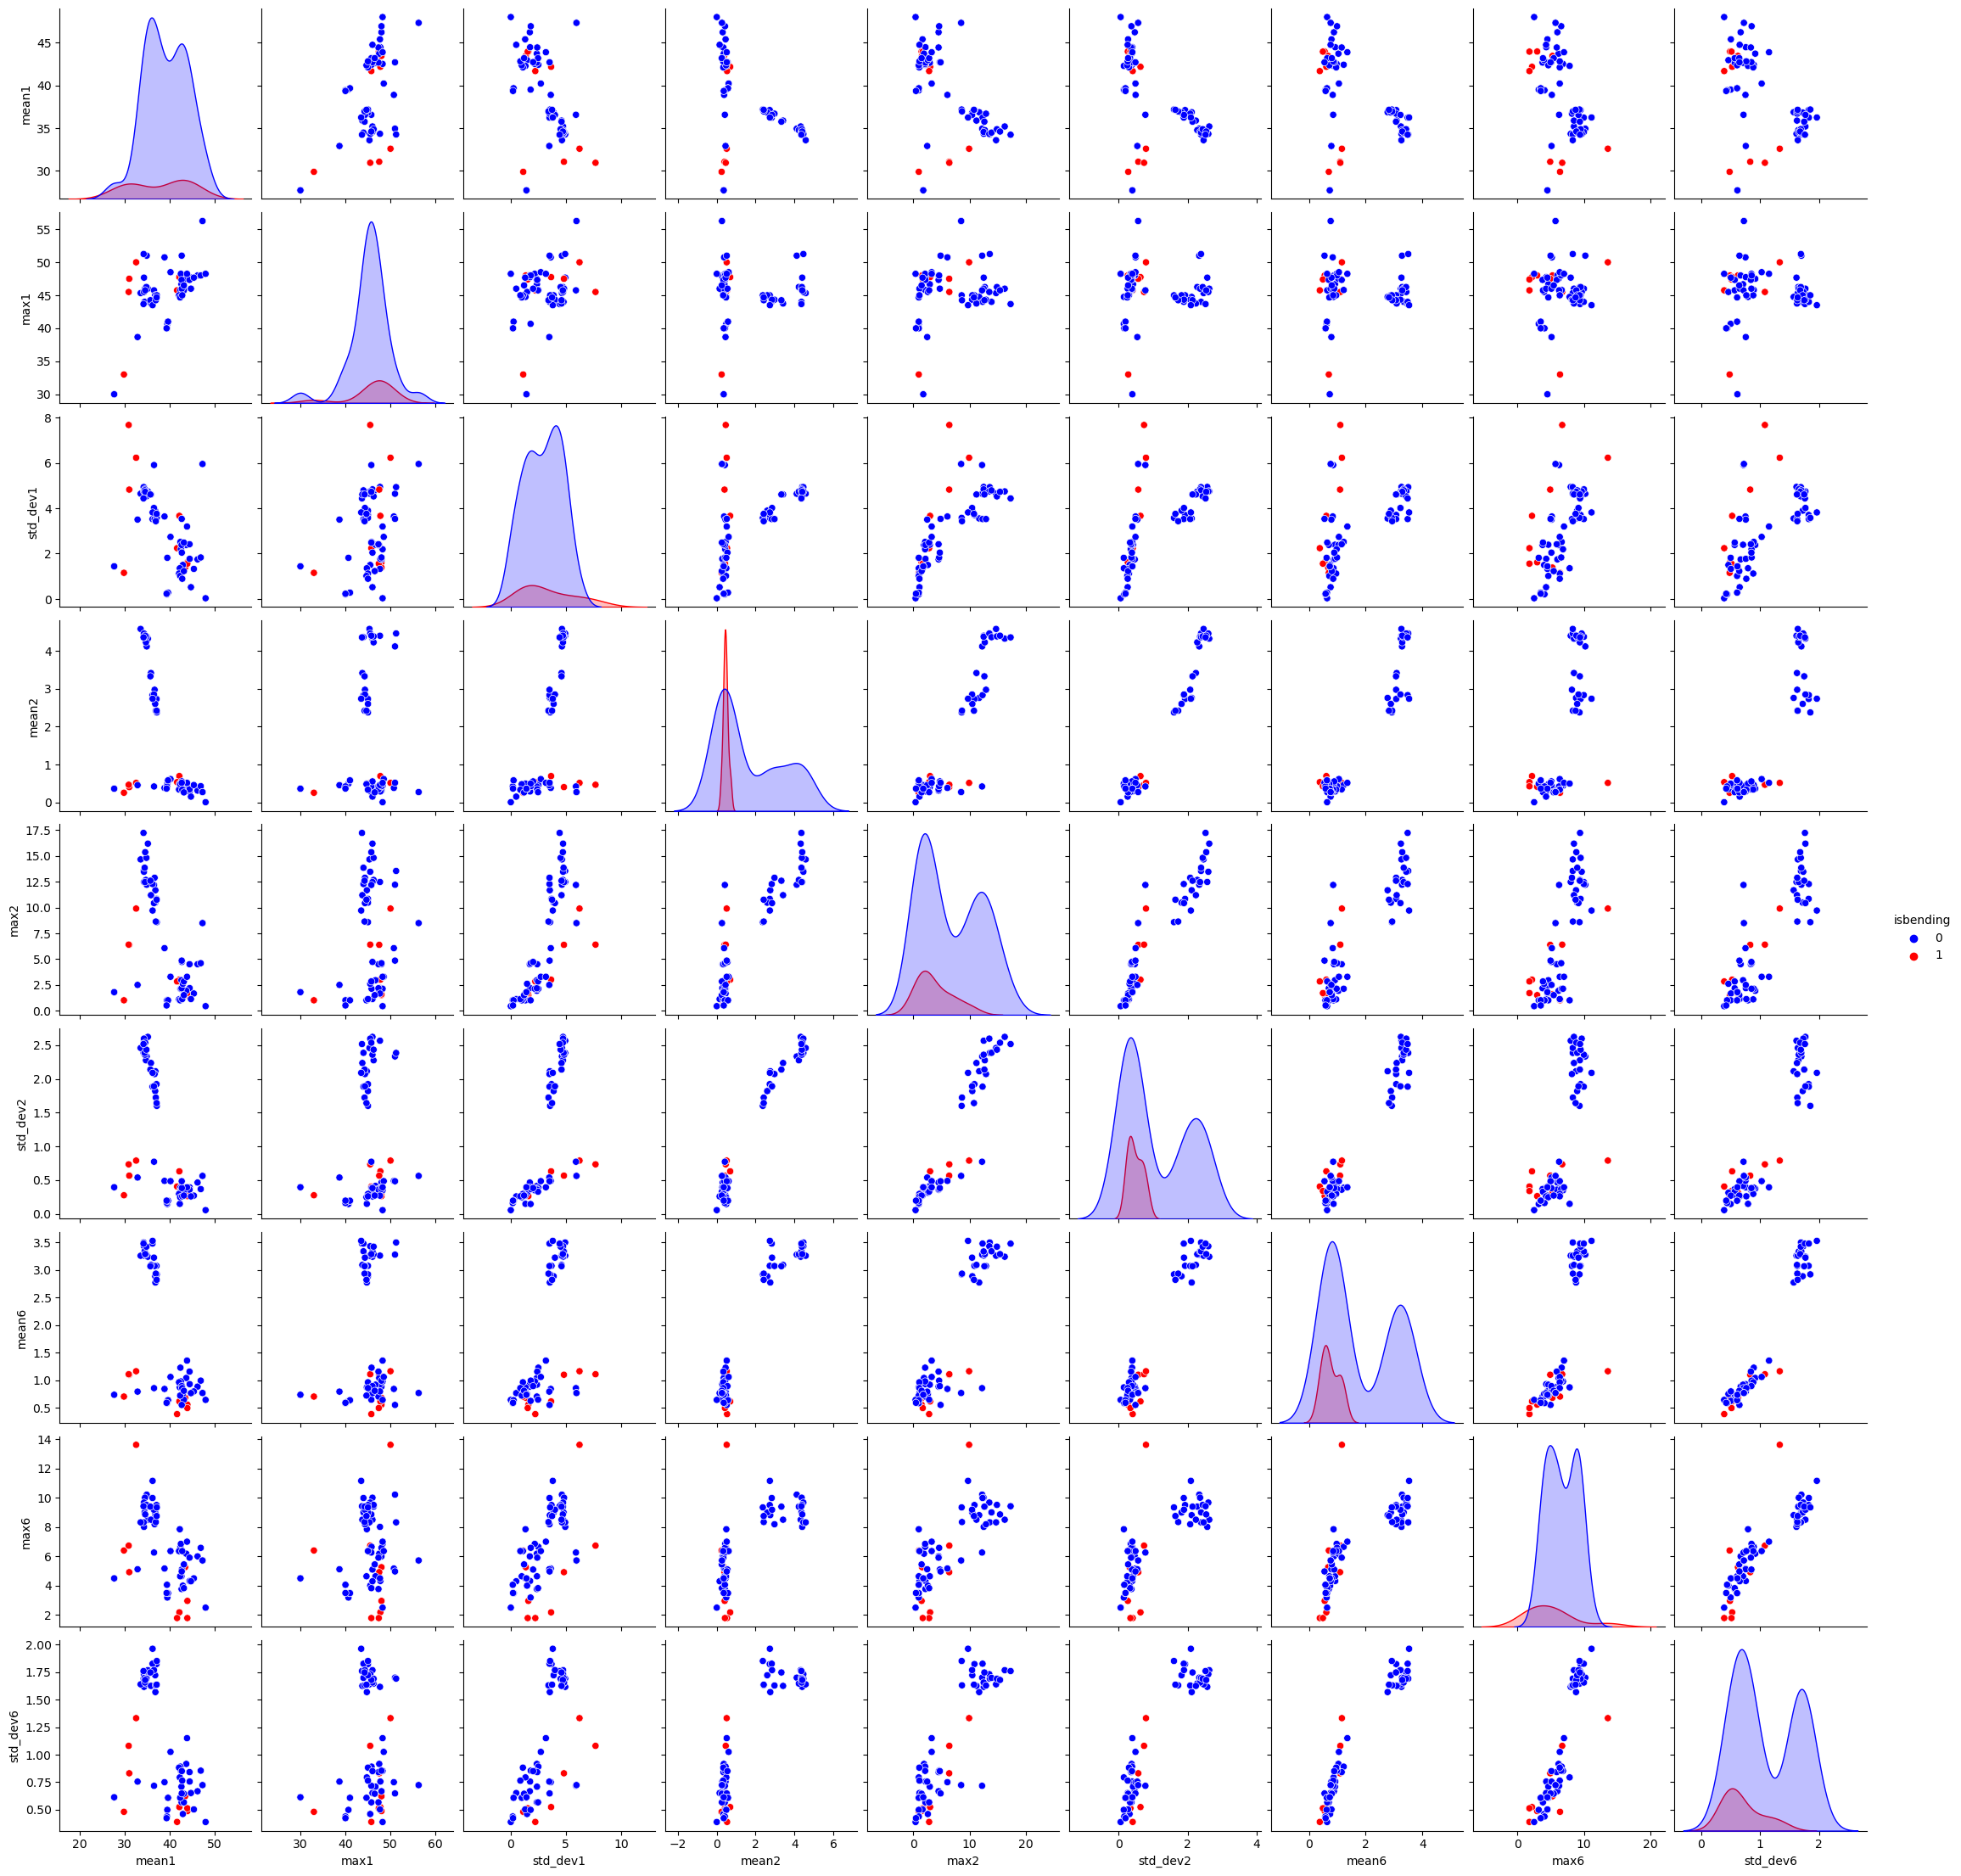

In [8]:
features_to_plot = ['mean1', 'max1', 'std_dev1', 'mean2', 'max2', 'std_dev2', 'mean6', 'max6', 'std_dev6']
features_df2['isbending'] = features_df2['isbending'].astype('category')

# the pairplot
sns.pairplot(features_df2[features_to_plot + ['isbending']], hue='isbending', palette={1: 'red', 0: 'blue'})


#### ii. Splitted Plots

/Users/purvaingle/opt/anaconda3/envs/HW2/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


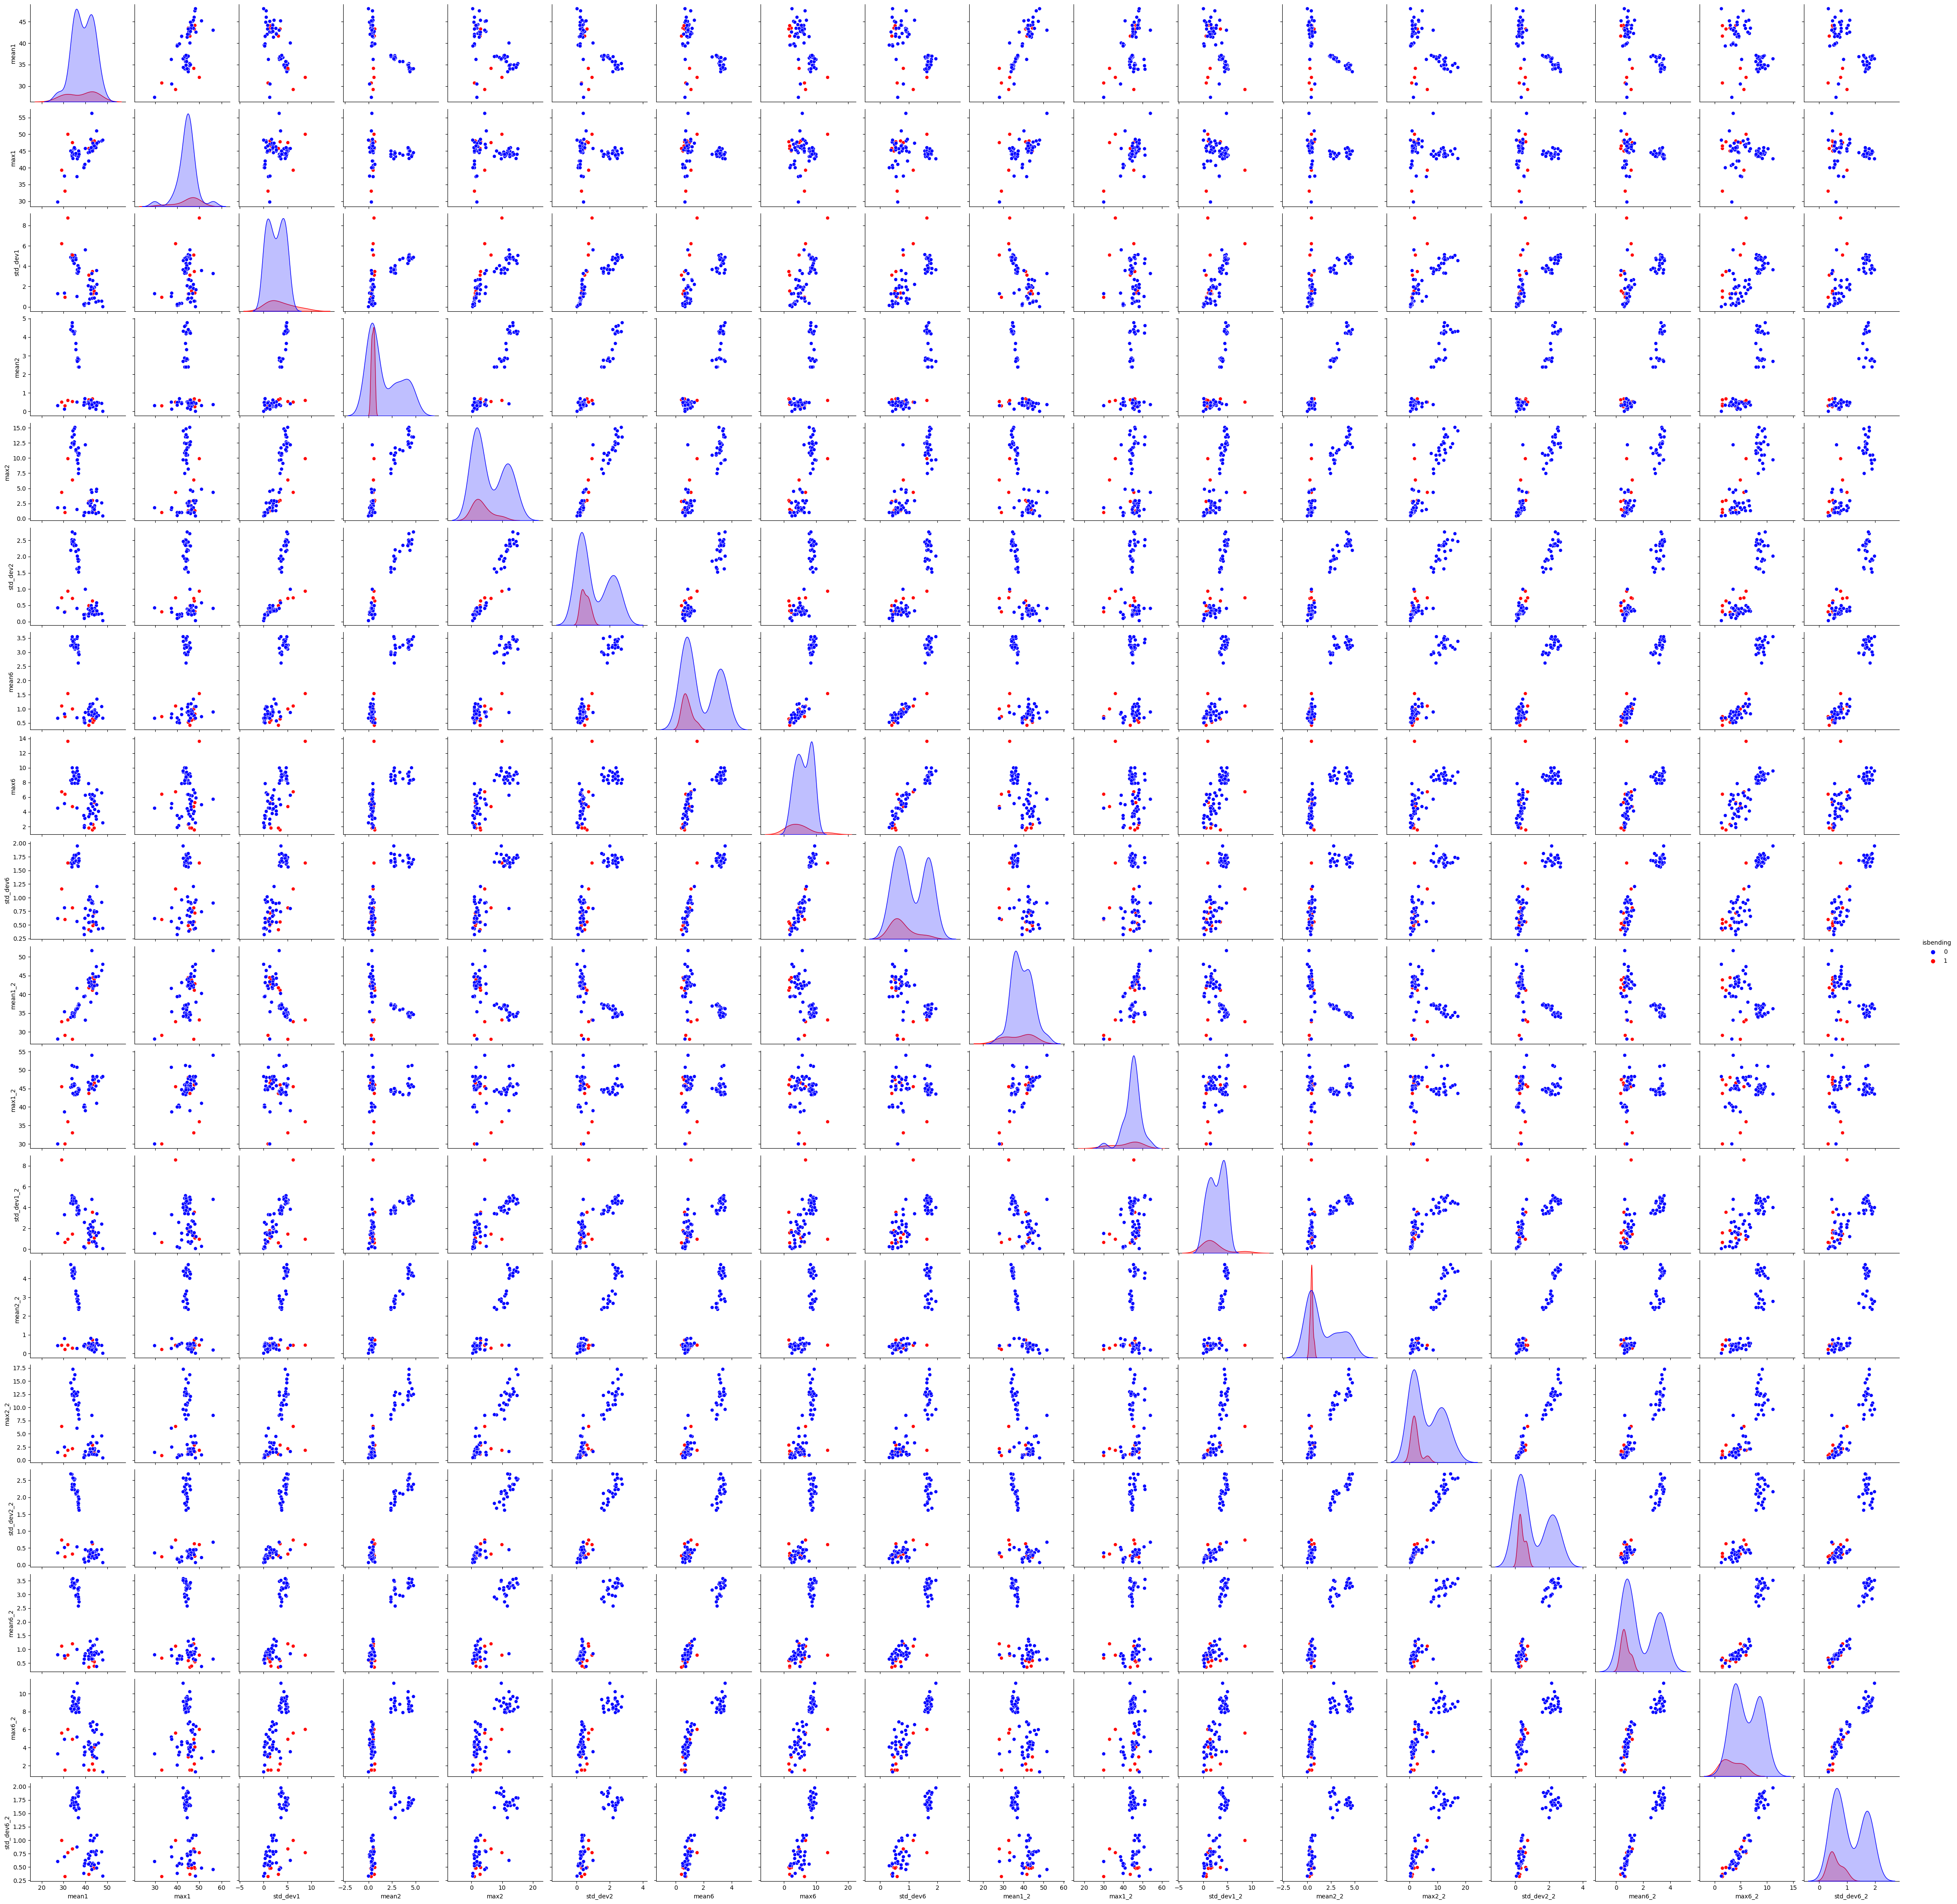

In [9]:
features_to_plot_split1 = ['mean1', 'max1', 'std_dev1', 'mean2', 'max2', 'std_dev2', 'mean6', 'max6', 'std_dev6']
features_to_plot_split2 = ['mean1_2', 'max1_2', 'std_dev1_2', 'mean2_2', 'max2_2', 'std_dev2_2', 'mean6_2', 'max6_2', 'std_dev6_2', 'isbending']

time_series_names = ['avg_rss12', 'var_rss12', 'var_rss23']

features_df3 = pd.DataFrame(columns=features_to_plot_split1)
features_df4 = pd.DataFrame(columns=features_to_plot_split2)
        
for key, value in train_data.items():
    is_bending = 1 if 'bending' in key else 0
    instance_features_part1 = []
    instance_features_part2 = []
    for i in time_series_names:
        
        split_idx = len(value[i]) // 2
        time_series_data_part1 = value[i][:split_idx]
        time_series_data_part2 = value[i][split_idx:]

        features_part1 = extract_time_domain_features2(time_series_data_part1)
        features_part2 = extract_time_domain_features2(time_series_data_part2)
        
        instance_features_part1.extend(list(features_part1.values()))
        instance_features_part2.extend(list(features_part2.values()))

    instance_features_part2.append(is_bending)
    features_df3.loc[len(features_df3)] = instance_features_part1
    features_df4.loc[len(features_df4)] = instance_features_part2

    combined_df = pd.concat([features_df3, features_df4], axis=1)
    combined_df['isbending'] = combined_df['isbending'].astype(int)
   
    
# print(combined_df)
        
combined_df['isbending'] = combined_df['isbending'].astype('category')

comb_features_to_plot = ['mean1', 'max1', 'std_dev1', 'mean2', 'max2', 'std_dev2', 'mean6', 'max6', 'std_dev6', 'mean1_2', 'max1_2', 'std_dev1_2', 'mean2_2', 'max2_2', 'std_dev2_2', 'mean6_2', 'max6_2', 'std_dev6_2']
# print(comb_features_to_plot)
sns.pairplot(combined_df[comb_features_to_plot + ['isbending']], hue='isbending', palette={1: 'red', 0: 'blue'})


### Explanation: 
I don't see any considerable difference between the results of 2(a)i and 2(a)ii. The two results seem to be very similar.

#### iii. Time Series Segments

In [10]:
#code to split the data
col_titles = ['avg_rss12', 'var_rss12',  'avg_rss13',  'var_rss13',  'avg_rss23' , 'var_rss23']

def split_time_series(data, l):
    split_data = np.array_split(data, l)
    return split_data
time_dict_list=[]
time_dict = {}
# Iterate through each file in train_data

for file_path, data in train_data.items():
    l_values = range(1, 21)
    for l in l_values:
        train_data2={}
        split_data = split_time_series(data, l)
        train_data2[file_path + f"_split_{l}_"] = split_data
#         print("split data 0", split_data[0])
#         print(train_data2)
        for k, v in train_data2.items():
            
            feature_columns_new = []
            feature_columns_new2=[]
            is_bending = 1 if 'bending' in k else 0
            for i in range(1, 7):
                for feature in ['mean', 'max', 'std_dev']:
                    feature_columns_new.append(f"{feature}{i}")
                    
#             print(feature_columns_new)

            for j in range(1, len(v) + 1):
                for feature in feature_columns_new:
                    feature_columns_new2.append(f"{feature}_split_{j}_")
                    
            feature_columns_new2.append("is_bending")
#             print(feature_columns_new2)
            time_features_df = pd.DataFrame(columns=feature_columns_new2)
            instance_features_new = []
            for table in v:
                df_new = pd.DataFrame(table)
                
                for ts in col_titles:
                    features_partly = extract_time_domain_features2(df_new[ts])
                    instance_features_new.extend(list(features_partly.values()))
                    
#                 print(instance_features_new)
            instance_features_new.append(is_bending)
            time_features_df.loc[len(time_features_df)] = instance_features_new
#             table_comb.loc[len(table_comb)] = time_features_df
#             print(time_features_df)            
            time_dict[k] = time_features_df
#         time_dict_list.append(time_dict)
# print(time_dict_list)
# print(time_dict)

        
            

In [11]:
array_of_dfs = []

for p in range(1, 21):
    concatenated_df = pd.DataFrame()
    for k,v in time_dict.items():
        if f"split_{p}_" in k:
#             print(k)
            concatenated_df = pd.concat([concatenated_df, v])
    concatenated_df['is_bending'] = concatenated_df['is_bending'].astype(int)
    array_of_dfs.append(concatenated_df)
    
  
# print(len(array_of_dfs))
print(array_of_dfs)


[    mean1_split_1_  max1_split_1_  std_dev1_split_1_  mean2_split_1_  \
0        43.969125          48.00           1.616677        0.413125   
0        43.454958          48.00           1.384653        0.378083   
0        42.179812          47.75           3.666840        0.696042   
0        41.678063          45.75           2.241152        0.535979   
0        43.954500          47.40           1.557210        0.426250   
..             ...            ...                ...             ...   
0        35.752354          44.25           4.609992        3.328104   
0        37.177042          45.00           3.577569        2.374208   
0        36.244083          43.50           3.818032        2.736021   
0        36.957458          44.25           3.431283        2.420083   
0        37.144833          44.67           3.754986        2.419062   

    max2_split_1_  std_dev2_split_1_  mean3_split_1_  max3_split_1_  \
0            1.50           0.262837       15.868021          2

In [12]:
# Logistic Regression Function
def log_reg(trainX_d,trainY_d, cv_d):
    cross_val = StratifiedKFold(n_splits = cv_d, shuffle = True, random_state = 69)
    model_d = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector_d = RFECV(estimator = model_d, cv = cross_val, scoring = 'accuracy')
    selector_d.fit(trainX_d, trainY_d)
    tesAcc = selector_d.cv_results_['mean_test_score'].max()
    return model_d, selector_d, tesAcc, (1 - tesAcc) 

In [13]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")
cv = 5
result = {'l-value': [], 'p': [], 'training score': [], 'training error': []}
for l in range(0, 20):
    trainX = array_of_dfs[l].iloc[:, :-1]
    trainY = array_of_dfs[l].iloc[:, -1]
#     print(trainX)
#     print(trainY)
    model, selector, score, error = log_reg(trainX,trainY, cv)
    
    result['l-value'].append(l+1)
    result['p'].append(selector.n_features_)
    result['training score'].append(score)
    result['training error'].append(error)

scores = pd.DataFrame(result)
print(scores)
# trainX2=trainX
# trainY2=trainY

    l-value   p  training score  training error
0         1   5        0.971429        0.028571
1         2   2        0.957143        0.042857
2         3   1        0.971429        0.028571
3         4   6        0.971429        0.028571
4         5   4        0.971429        0.028571
5         6   4        0.957143        0.042857
6         7  13        0.971429        0.028571
7         8   3        0.971429        0.028571
8         9   1        0.971429        0.028571
9        10  13        0.971429        0.028571
10       11  10        0.971429        0.028571
11       12   8        0.971429        0.028571
12       13   5        0.971429        0.028571
13       14  32        0.985714        0.014286
14       15  45        0.985714        0.014286
15       16  23        0.985714        0.014286
16       17  56        0.985714        0.014286
17       18   3        0.984615        0.015385
18       19   5        0.971429        0.028571
19       20  32        0.985714        0

In [14]:
best_index = scores['training score'].argmax()
l_value = scores['l-value'][best_index]
print(f"The optimal pair is: (l = {l_value}, p = {scores['p'][best_index]})\n")
l = best_index + 1

The optimal pair is: (l = 14, p = 32)



In [15]:
#Splitting it again using best l value discovered
time_dict2={}
for file_path, data in train_data.items():
    l_val = 14

    train_data14={}
    split_data = split_time_series(data, l_val)
    train_data14[file_path + f"_split_{l_val}_"] = split_data
    
    for k, v in train_data14.items():
            
        feature_columns_new3 = []
        feature_columns_new4=[]
        is_bending = 1 if 'bending' in k else 0

        for i in range(1, 7):
            for feature in ['mean', 'max', 'std_dev']:
                feature_columns_new3.append(f"{feature}{i}")

        for j in range(1, l + 1):
            for feature in feature_columns_new3:
                feature_columns_new4.append(f"{feature}_split_{j}_")
                    
        feature_columns_new4.append("is_bending")
#         print(len(feature_columns_new4))
        time_features_df2 = pd.DataFrame(columns=feature_columns_new4)
        instance_features_new2 = []
        for table in v:
            df_new2 = pd.DataFrame(table)
                
            for ts in col_titles:
                features_partly2 = extract_time_domain_features2(df_new2[ts])
                instance_features_new2.extend(list(features_partly2.values()))
                    
#                 print(instance_features_new)
        instance_features_new2.append(is_bending)
#         print(len(instance_features_new2))
        time_features_df2.loc[len(time_features_df2)] = instance_features_new2
#             table_comb.loc[len(table_comb)] = time_features_df
#             print(time_features_df)            
        time_dict2[k] = time_features_df2
    
# print(time_dict2)

In [16]:
concatenated_df2 = pd.DataFrame()
for k,v in time_dict2.items():
    concatenated_df2 = pd.concat([concatenated_df2, v])
    concatenated_df2['is_bending'] = concatenated_df2['is_bending'].astype(int)
    
print(concatenated_df2)

    mean1_split_1_  max1_split_1_  std_dev1_split_1_  mean2_split_1_  \
0        42.698571          44.25           0.851148        0.458857   
0        44.804571          46.75           1.011238        0.226571   
0        43.568857          47.50           3.554563        0.688857   
0        41.613143          45.00           2.211107        0.455714   
0        43.938000          45.00           1.466038        0.308571   
..             ...            ...                ...             ...   
0        36.107143          44.00           4.754422        3.266000   
0        36.566571          43.25           4.000746        2.526286   
0        36.776286          42.00           3.239910        2.719143   
0        36.795143          42.75           3.629977        2.554571   
0        36.917143          43.00           3.526904        2.264571   

    max2_split_1_  std_dev2_split_1_  mean3_split_1_  max3_split_1_  \
0            0.94           0.274765       15.924857          21

In [17]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

trainX = concatenated_df2.iloc[:, :-1]
trainY = concatenated_df2.iloc[:, -1]
model, selector, score, error = log_reg(trainX, trainY, 5)

In [18]:
selected_features = []
for i, feature in enumerate(feature_columns_new4[:-1]):
    if selector.support_[i]:
        selected_features.append(feature)
        
print("p = ",len(selected_features))
print("selected features are:", selected_features)

p =  32
selected features are: ['mean5_split_1_', 'max5_split_1_', 'mean3_split_2_', 'mean5_split_2_', 'max5_split_2_', 'mean5_split_3_', 'max5_split_3_', 'mean5_split_4_', 'max5_split_4_', 'max6_split_4_', 'max2_split_5_', 'mean5_split_5_', 'max5_split_5_', 'max6_split_5_', 'max1_split_7_', 'max1_split_8_', 'mean5_split_8_', 'max5_split_8_', 'mean1_split_9_', 'max1_split_9_', 'mean1_split_10_', 'max1_split_10_', 'mean3_split_10_', 'max4_split_10_', 'mean1_split_11_', 'max1_split_11_', 'mean3_split_13_', 'max3_split_13_', 'max4_split_13_', 'mean5_split_13_', 'max6_split_13_', 'mean5_split_14_']


## What are the right way and the wrong way to perform cross-validation in this problem?

Performing Recursive Feature Elimination (RFE) with Cross Validation is the correct way for this problem. This way we allow the algorithm to evaluate the importance of features while considering different subsets of the data in each fold of the cross-validation process.

But if we perform RFE before Cross Validation, we would essentially be removing features from the dataset before allowing the algorithm to evaluate its performance. This could lead to suboptimal results because the algorithm would not have access to the full set of predictors during the evaluation process.

Hence, the right way is Recursive Feature Elimination (RFE) with Cross Validation and the wrong way is RFE before Cross Validation.

#### iv. Confusion Matrix

In [19]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")
model.fit(trainX.loc[:, selected_features], trainY.to_numpy(dtype="int"))
pred_y = model.predict(trainX.loc[:, selected_features])
pred_y = pred_y.round()
true_y = trainY.to_numpy(dtype=float)
t_score = model.score(trainX.loc[:, selected_features], trainY.to_numpy(dtype="int"))
print(f"Accuracy: {t_score}")

#confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 1.0
Confusion Matrix:
[[60  0]
 [ 0  9]]


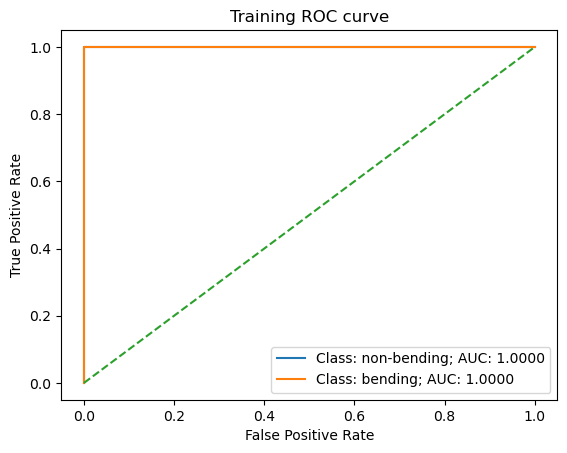

In [20]:
pred_y_prob = model.predict_proba(trainX.loc[:, selected_features])
binary_class_dict = {0: 'non-bending', 1: 'bending'}

fig, axes = plt.subplots()

for class_ in model.classes_:
    y_pred = pred_y_prob[:, class_]
    fpr, tpr, thresholds = roc_curve(true_y, y_pred, pos_label=class_)
    roc_auc = auc(fpr, tpr)

    # labels
    class_label = binary_class_dict[class_] if len(model.classes_) == 2 else rev_classes_[class_]
    label = f"Class: {class_label}; AUC: {roc_auc:.4f}"

    # plot
    axes.plot(fpr, tpr, label=label)

axes.plot([0, 1], [0, 1], "--")
axes.set_title("Training ROC curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()

plt.show()

In [21]:
trainX = concatenated_df2.iloc[:, :-1]
trainY = concatenated_df2.iloc[:, -1]
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype = float))
model2 = sm.Logit(trainY.to_numpy(dtype = float), const_val)
summary = model2.fit(method = 'bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                           32
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        21:36:11   Log-Likelihood:            -1.3232e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                   0.01012
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0379    4.5e+04  -8.4

In [22]:

def split_data(l, data_dict):
    time_feat_dict={}
    for file_path, data in data_dict.items():
        train_data_dict={}
        split_data_ = split_time_series(data, l)
        train_data_dict[file_path + f"_split_{l}_"] = split_data_

        for k, v in train_data_dict.items():

            feature_columns_1 = []
            feature_columns_2=[]
#             print(k)
            is_bending = int('bending' in k)
            for i in range(1, 7):
                for feature in ['mean', 'max', 'std_dev']:
                    feature_columns_1.append(f"{feature}{i}")

            for j in range(1, l + 1):
                for feature in feature_columns_1:
                    feature_columns_2.append(f"{feature}_split_{j}_")

            feature_columns_2.append("is_bending")
#             print(feature_columns_2)
            time_features_df_new = pd.DataFrame(columns=feature_columns_2)
            instance_features_ = []
            for table in v:
                df_new_ = pd.DataFrame(table)
                for ts in col_titles:
                    features_partly_ = extract_time_domain_features2(df_new_[ts])
                    instance_features_.extend(list(features_partly_.values()))

            instance_features_.append(is_bending)
            time_features_df_new.loc[len(time_features_df_new)] = instance_features_
            time_feat_dict[k] = time_features_df_new

    concatenated_df_ = pd.DataFrame()
    for k,v in time_feat_dict.items():
        concatenated_df_ = pd.concat([concatenated_df_, v])
        concatenated_df_['is_bending'] = concatenated_df_['is_bending'].astype(int)
#     print(time_feat_dict)
    return concatenated_df_, feature_columns_2
    
# print(time_feat_dict)

In [23]:
multi_classes2 = {0: 'bending', 1: 'cycling', 2: 'lying', 3: 'sitting', 4: 'standing', 5: 'walking'}

#function to plot ROC curve
def plot_roc_auc(model_, true_y_d, predY_prob):    
    fig_, axes_ = plt.subplots()

    for class_ in model_.classes_:
#         print(class_)
        y_pred_ = predY_prob[:, int(class_)]
        fpr_, tpr_, thresholds_ = roc_curve(true_y_d, y_pred_, pos_label=class_)
        roc_auc_ = auc(fpr_, tpr_)

        if len(model_.classes_) == 2:
            class_label_ = binary_class_dict[class_]
        else:
            class_label_ = multi_classes2[class_]

        label_ = f"Class: {class_label_}; AUC: {roc_auc_}"
        axes_.plot(fpr_, tpr_, label=label_)

    axes_.plot([0, 1], [0, 1], "--")
    axes_.set_title("ROC curve")
    axes_.set_xlabel("False Positive Rate")
    axes_.set_ylabel("True Positive Rate")
    axes_.legend()

    # Show the plot
    plt.show()

In [24]:
def CM(model_, df_X, df_Y, selected_features_, fitagain = False):

    if not fitagain:
        model_.fit(df_X.loc[:, selected_features_], df_Y.to_numpy(dtype="int"))

    pred_y_ = model_.predict(df_X.loc[:, selected_features_])
    pred_y_prob_ = model_.predict_proba(df_X.loc[:, selected_features_])

    pred_y_ = pred_y_.round()
    true_y_ = df_Y.to_numpy(dtype=float)
#     print(len(true_y_))

    t_score_ = model_.score(df_X.loc[:, selected_features_], df_Y.to_numpy(dtype="int"))
    print(f"Accuracy: {t_score_}")

    conf_matrix_ = confusion_matrix(true_y_, pred_y_)
    print("Confusion Matrix:")
    print(conf_matrix_)
#     print(pred_y_prob_)
    
    plot_roc_auc(model_, true_y_, pred_y_prob_)


#### v. Test Classifier

Accuracy: 1.0
Confusion Matrix:
[[15  0]
 [ 0  4]]


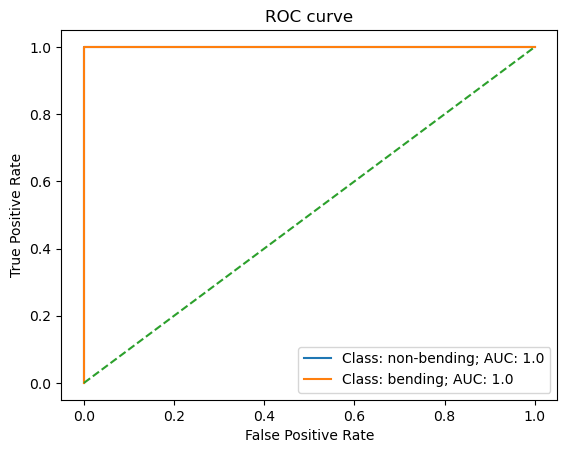

In [25]:
# print(test_data)
time_feat_df, feature_cols = split_data(14, test_data )
# print(time_feat_df)

testX, testY = time_feat_df.iloc[:, :-1], time_feat_df.iloc[:, -1]
# testX
# testY
CM(model, testX, testY, selected_features, True)

## Explanation: 
The train and test accuracy are the same.

#### vi. Separation

The p-values and our results suggest that there is a complete separation of the classes. In this situation, the Maximum Likelihood Estimator (MLE), a statistical method used to estimate model parameters, does not exist.

In essence, because the classes are perfectly separated, it's challenging for the model to accurately estimate the relationships between variables, leading to potential issues in the regression analysis.


#### vii. Imbalance

From the confusion matrices obtained, I do see imbalanced classes. 

In [26]:
from imblearn.over_sampling import RandomOverSampler

def sample_data(data_frX, data_frY):

    ros = RandomOverSampler(random_state=60)
    X_resampled, y_resampled = ros.fit_resample(data_frX, data_frY)
   
    return X_resampled, y_resampled

In [27]:
cv = 5
result = {'l-value': [], 'p': [], 'training score': [], 'training error': []}
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

for l in range(0, 20):
    trainX = array_of_dfs[l].iloc[:, :-1]
    trainY = array_of_dfs[l].iloc[:, -1]
    
    X = pd.DataFrame()
    Y = pd.DataFrame()
    X, Y= sample_data(trainX, trainY)

    model_3, selector_3, score_3, error_3 = log_reg(X,Y, cv)
    
    result['l-value'].append(l+1)
    result['p'].append(selector_3.n_features_)
    result['training score'].append(score_3)
    result['training error'].append(error_3)

result = pd.DataFrame(result)
result

l-value   p  training score  training error
0         1   3        0.991667        0.008333
1         2   7        0.983333        0.016667
2         3   3        0.991667        0.008333
3         4   3        1.000000        0.000000
4         5   2        0.991667        0.008333
5         6   5        0.991667        0.008333
6         7   4        1.000000        0.000000
7         8   3        0.991667        0.008333
8         9   2        0.991667        0.008333
9        10   3        0.991667        0.008333
10       11   5        0.991667        0.008333
11       12   3        0.991667        0.008333
12       13   2        0.991667        0.008333
13       14   8        1.000000        0.000000
14       15   3        0.991667        0.008333
15       16  12        1.000000        0.000000
16       17   2        1.000000        0.000000
17       18   3        1.000000        0.000000
18       19   2        0.991667        0.008333
19       20   3        0.991667        0.008333

In [28]:
#printing number of elements in each class
# print(len(X))
# print(len(Y))
class_counts = Y.value_counts()
print(class_counts)

is_bending
1    60
0    60
Name: count, dtype: int64


In [29]:
best_index = result['training score'].argmax()
l_value = result['l-value'][best_index]
print(f"The optimal pair is: (l = {l_value}, p = {result['p'][best_index]})\n")
l = best_index + 1
# print(l)

train_split4 , feat_cols= split_data(l, train_data)
# print(feat_cols)

The optimal pair is: (l = 4, p = 3)



p =  3
selected features are: ['mean5_split_1_', 'mean1_split_3_', 'max6_split_4_']
Accuracy: 1.0
Confusion Matrix:
[[15  0]
 [ 0  4]]


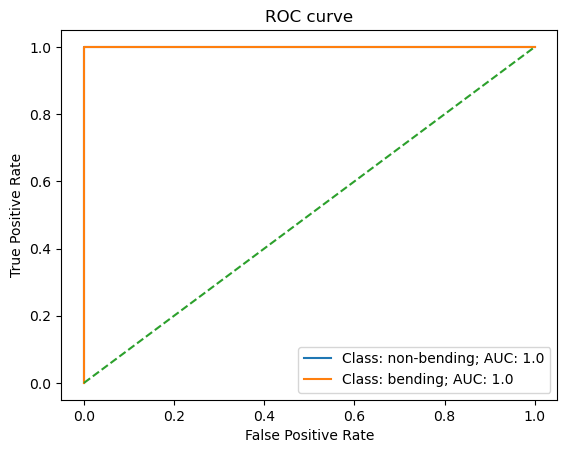

In [30]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

trainX4 = train_split4.iloc[:, :-1]
trainY4 = train_split4.iloc[:, -1]

X2 = pd.DataFrame()
Y2 = pd.DataFrame()
X2, Y2= sample_data(trainX4, trainY4)

model4, selector4, score4, error4 = log_reg(X2, Y2, cv)
# print(selector4.n_features_)
selected_features2 = []
for i, feature in enumerate(feat_cols[:-1]):
    if selector4.support_[i]:
        selected_features2.append(feature)
        
print("p = ",len(selected_features2))
print("selected features are:", selected_features2)

time_feat_df4, feature_cols4 = split_data(4, test_data )
# print(time_feat_df)

testX_, testY_ = time_feat_df4.iloc[:, :-1], time_feat_df4.iloc[:, -1]
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

testX2 = pd.DataFrame()
testY2 = pd.DataFrame()

# CM(model4, testX_, testY_, selected_features2, True)
# if not fitagain:
model4.fit(testX_.loc[:, selected_features2], testY_.to_numpy(dtype="int"))

pred_y_ = model4.predict(testX_.loc[:, selected_features2])
pred_y_prob_ = model4.predict_proba(testX_.loc[:, selected_features2])

pred_y_ = pred_y_.round()
true_y_ = testY_.to_numpy(dtype=float)
# #     print(len(true_y_))

t_score_ = model4.score(testX_.loc[:, selected_features2], testY_.to_numpy(dtype="int"))
print(f"Accuracy: {t_score_}")

conf_matrix_ = confusion_matrix(true_y_, pred_y_)
print("Confusion Matrix:")
print(conf_matrix_)
#     print(pred_y_prob_)
    
plot_roc_auc(model4, true_y_, pred_y_prob_)



### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [31]:
def index_find(model, c_dict):
    for i, c in enumerate(model.Cs_):
        if (c == c_dict): 
            return i

In [47]:
def binary_log_reg(train_data, test_data, l, cv_factor, cm_roc = False):
    
    feature_cols = []
    train_df, feature_cols = split_data(l, train_data)
    test_df, feature_cols = split_data(l, test_data)

    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    
    scaler = StandardScaler()

    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)

    model = LogisticRegressionCV(penalty = 'l1', max_iter = 100, scoring = 'accuracy',
                                     cv = cv_factor, random_state = 69, solver = 'liblinear')  
    model.fit(trainX, trainY)
    train_predictions = model.predict_proba(trainX)
    test_predictions = model.predict_proba(testX)
    predicted_y = model.predict(testX)
    i = index_find(model, model.C_[0])
    train_score = np.mean(model.scores_[1][:, i])
    test_score = model.score(testX, testY)

    train_error = 1 - train_score
    
    if cm_roc != False:
        confusion_matrix_result = confusion_matrix(testY, predicted_y)

        print(f"Confusion matrix for test data:\n{confusion_matrix_result}")
        print("\nROC Curve for Training Data")
        plot_roc_auc(model, trainY, train_predictions)

        print("\nROC Curve for Testing Data")
        plot_roc_auc(model, testY, test_predictions)
        print("Test accuracy: ", test_score )
        print("Test error: ", (1- test_score) )
        return [train_score, test_score]
   
    return [l, train_score, train_error]


In [48]:
global train_acc
train_acc = 0
global val_l
val_l = 1
cv = 5
l_size = 20
res = []
warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn.linear_model._logistic")

for l in range(1, l_size + 1):
    res.append(binary_log_reg(train_data, test_data, l, cv, False))

    if res[-1][1] > train_acc:
        train_acc = res[-1][1]
        val_l = l

result_df = pd.DataFrame(res, columns=['l-value', 'training score', 'training error'])
result_df

l-value  training score  training error
0         1        0.957143        0.042857
1         2        0.928571        0.071429
2         3        0.942857        0.057143
3         4        0.942857        0.057143
4         5        0.957143        0.042857
5         6        0.957143        0.042857
6         7        0.942857        0.057143
7         8        0.942857        0.057143
8         9        0.942857        0.057143
9        10        0.942857        0.057143
10       11        0.942857        0.057143
11       12        0.957143        0.042857
12       13        0.957143        0.042857
13       14        0.942857        0.057143
14       15        0.928571        0.071429
15       16        0.957143        0.042857
16       17        0.957143        0.042857
17       18        0.957143        0.042857
18       19        0.971429        0.028571
19       20        0.957143        0.042857

Best l value = 19. 
Best training accuracy = 0.9714285714285715

testing data with l = 19

Confusion matrix for test data:
[[15  0]
 [ 1  3]]

ROC Curve for Training Data


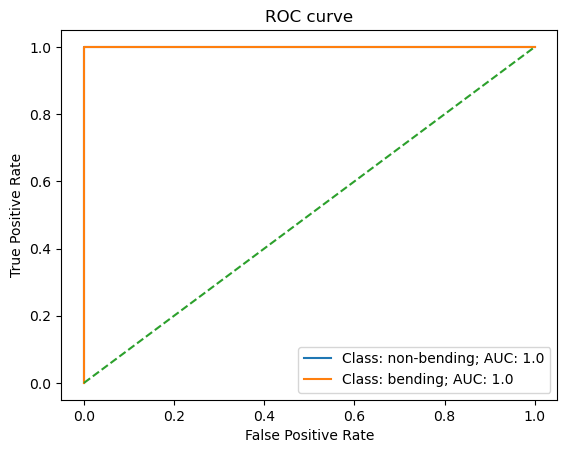


ROC Curve for Testing Data


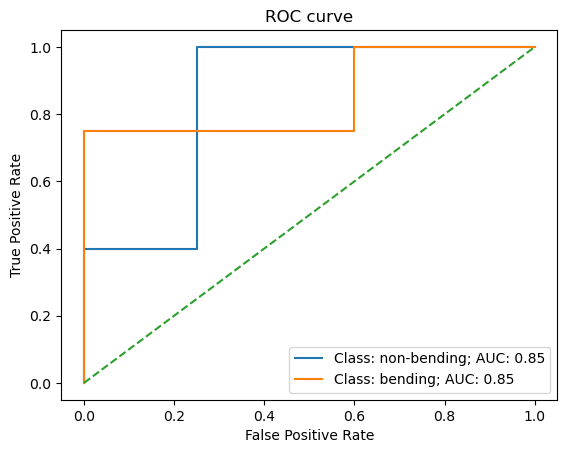

Test accuracy:  0.9473684210526315
Test error:  0.052631578947368474


[0.9714285714285715, 0.9473684210526315]

In [49]:
print(f"Best l value = {val_l}. \nBest training accuracy = {train_acc}\n")
print(f"testing data with l = {val_l}\n")

binary_log_reg(train_data, test_data, val_l, cv, True)

#### ii. Comparison


L1- penalized logistic regression is easier to implement because we don't need to do manual feature selection. But, L1-penalized logistic regression performs worse if we compare the ROC curves and the AUC of the test data of both these methods. We can see that it has lower test accuracy than RFECV logistic regression.  

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [50]:
multi_classes = {'cycling': 1, 'lying': 2, 'sitting': 3, 'standing': 4, 'walking': 5}

def classValue(key):
    key = key.split('/')[3]
    if key in ['bending1', 'bending2']:
        return 0
    return multi_classes[key]

def split_multiclass_data(l, data_dict):
    time_feat_dict={}
    for file_path, data in data_dict.items():
        train_data_dict={}
        split_data_ = split_time_series(data, l)
        train_data_dict[file_path + f"_split_{l}_"] = split_data_

        for k, v in train_data_dict.items():

            feature_columns_1 = []
            feature_columns_2=[]
            for i in range(1, 7):
                for feature in ['mean', 'max', 'std_dev']:
                    feature_columns_1.append(f"{feature}{i}")

            for j in range(1, l + 1):
                for feature in feature_columns_1:
                    feature_columns_2.append(f"{feature}_split_{j}_")

            feature_columns_2.append("is_bending")
            time_features_df_new = pd.DataFrame(columns=feature_columns_2)
            instance_features_ = []
            for table in v:
                df_new_ = pd.DataFrame(table)
                for ts in col_titles:
                    features_partly_ = extract_time_domain_features2(df_new_[ts])
                    instance_features_.extend(list(features_partly_.values()))

            instance_features_.append(classValue(k))
            time_features_df_new.loc[len(time_features_df_new)] = instance_features_
            time_feat_dict[k] = time_features_df_new

    concatenated_df_ = pd.DataFrame()
    for k,v in time_feat_dict.items():
        concatenated_df_ = pd.concat([concatenated_df_, v])
        concatenated_df_['is_bending'] = concatenated_df_['is_bending'].astype(int)
#     print(time_feat_dict)
    return concatenated_df_, feature_columns_2
    
# print(time_feat_dict)

In [52]:
global train_acc
train_acc = 0
global val_l
val_l = 1
res = []
# warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._split")

def multiclass(train_data, test_data, l, cm_roc = False):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    feature_cols = []
    train_df, feature_cols = split_multiclass_data(l, train_data)
    test_df, feature_cols = split_multiclass_data(l, test_data)
#     print(test_data)

    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    
    scaler = MinMaxScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)

    model = LogisticRegressionCV(penalty = 'l1', max_iter = 7000, multi_class = 'multinomial', cv = cv, solver = 'saga') 
    model.fit(trainX, trainY)
    train_predictions = model.predict_proba(trainX)
    test_predictions = model.predict_proba(testX)
    predicted_y = model.predict(testX)
    idx = index_find(model, model.C_[0])
    score = 0
    for class_ in model.scores_.keys():
#         print(class_)
        score += np.mean(model.scores_[class_][:, idx])
    train_score = score/len(model.scores_.keys())
    train_error = 1 - train_score
    test_score = model.score(testX, testY)
    
    if cm_roc != False:
        
        confusion_matrix_result = confusion_matrix(testY, predicted_y)

        print(f"Confusion matrix for test data:\n{confusion_matrix_result}")
        print("\nROC Curve for Training Data")
        plot_roc_auc(model, trainY, train_predictions)

        print("\nROC Curve for Testing Data")
        plot_roc_auc(model, testY, test_predictions)
        print("Test accuracy: ", test_score )
        print("Test error: ", (1- test_score) )
        
#         return [train_score, test_score]
   
    return [l, train_score, train_error]

warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn.linear_model._logistic")

for l in range(1, 21):
    res.append(multiclass(train_data, test_data, l, False))

    if res[-1][1] > train_acc:
        train_acc = res[-1][1]
        val_l = l

result_df = pd.DataFrame(res, columns=['l-value', 'training score', 'training error'])
result_df

l-value  training score  training error
0         1        0.927473        0.072527
1         2        0.898901        0.101099
2         3        0.856044        0.143956
3         4        0.870330        0.129670
4         5        0.840659        0.159341
5         6        0.828571        0.171429
6         7        0.784615        0.215385
7         8        0.827473        0.172527
8         9        0.784615        0.215385
9        10        0.797802        0.202198
10       11        0.797802        0.202198
11       12        0.814286        0.185714
12       13        0.770330        0.229670
13       14        0.769231        0.230769
14       15        0.783516        0.216484
15       16        0.825275        0.174725
16       17        0.798901        0.201099
17       18        0.783516        0.216484
18       19        0.769231        0.230769
19       20        0.783516        0.216484

Best l value = 1. 
Best training accuracy = 0.9274725274725276

testing data with l = 1

Confusion matrix for test data:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]

ROC Curve for Training Data


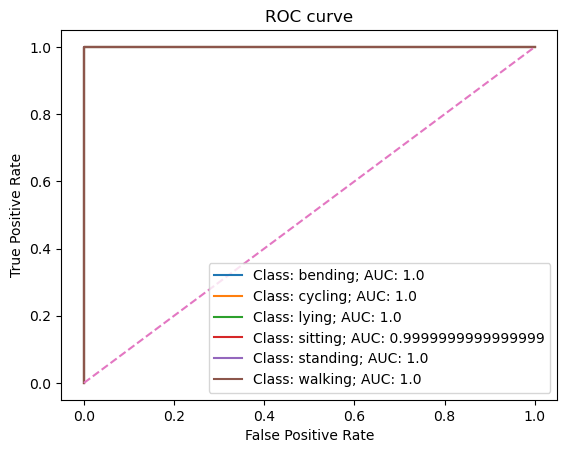


ROC Curve for Testing Data


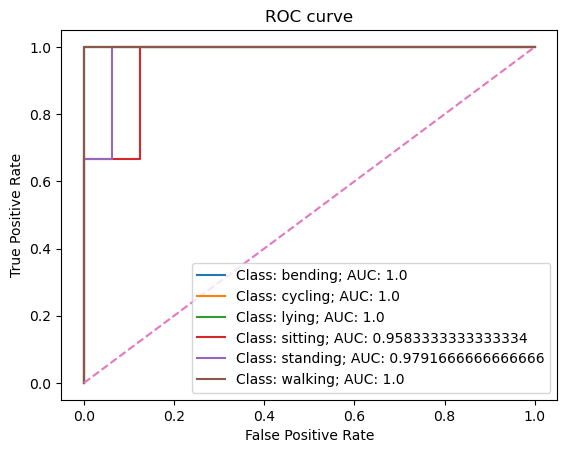

Test accuracy:  0.8947368421052632
Test error:  0.10526315789473684


[1, 0.9274725274725276, 0.07252747252747238]

In [53]:
print(f"Best l value = {val_l}. \nBest training accuracy = {train_acc}\n")
print(f"testing data with l = {val_l}\n")

multiclass(train_data, test_data, val_l, True)

#### ii. Naive Bayes

In [54]:
# warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._split")


global train_acc
train_acc = 0
global val_l
val_l = 1
res = []

def gaussian(train_data, test_data, l, prior, cm_roc = False):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    feature_cols = []
    train_df, feature_cols = split_multiclass_data(l, train_data)
    test_df, feature_cols = split_multiclass_data(l, test_data)

    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    scaler = MinMaxScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)

    model = GaussianNB()
    if prior == 'multinomial':
        model = MultinomialNB()
    
    model.fit(trainX, trainY)
    score = cross_val_score(estimator = model,X = trainX, y = trainY, cv = cv, scoring = "accuracy")
    train_score = np.mean(score)
    train_error = 1-train_score
    test_score = model.score(testX, testY)
    
    if cm_roc == True:
        train_predictions = model.predict_proba(trainX)
        test_predictions = model.predict_proba(testX)
        predicted_y = model.predict(testX)
        confusion_matrix_result = confusion_matrix(testY, predicted_y)

        print(f"Confusion matrix for test data:\n{confusion_matrix_result}")
        print("\nROC Curve for Training Data")
        plot_roc_auc(model, trainY, train_predictions)

        print("\nROC Curve for Testing Data")
        plot_roc_auc(model, testY, test_predictions)
        print("Test accuracy: ", test_score )
        print("Test error: ", (1- test_score) )
        
        return [train_score, test_score]
   
    return [l, train_score, train_error]

warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn.linear_model._logistic")

for l in range(1, 21):
    res.append(gaussian(train_data, test_data, l, "gaussian", False))

    if res[-1][1] > train_acc:
        train_acc = res[-1][1]
        val_l = l

result_df = pd.DataFrame(res, columns=['l-value', 'training score', 'training error'])
result_df

l-value  training score  training error
0         1        0.841758        0.158242
1         2        0.840659        0.159341
2         3        0.827473        0.172527
3         4        0.828571        0.171429
4         5        0.784615        0.215385
5         6        0.813187        0.186813
6         7        0.813187        0.186813
7         8        0.784615        0.215385
8         9        0.782418        0.217582
9        10        0.756044        0.243956
10       11        0.797802        0.202198
11       12        0.784615        0.215385
12       13        0.710989        0.289011
13       14        0.754945        0.245055
14       15        0.740659        0.259341
15       16        0.784615        0.215385
16       17        0.740659        0.259341
17       18        0.724176        0.275824
18       19        0.771429        0.228571
19       20        0.770330        0.229670

Best l value = 1. 
Best training accuracy = 0.8417582417582418

testing data with l = 1

Confusion matrix for test data:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]

ROC Curve for Training Data


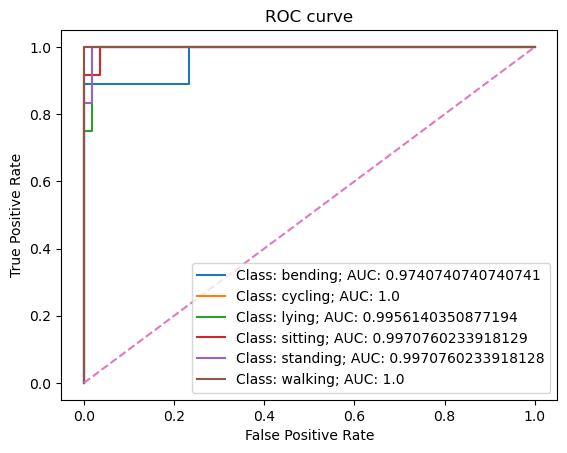


ROC Curve for Testing Data


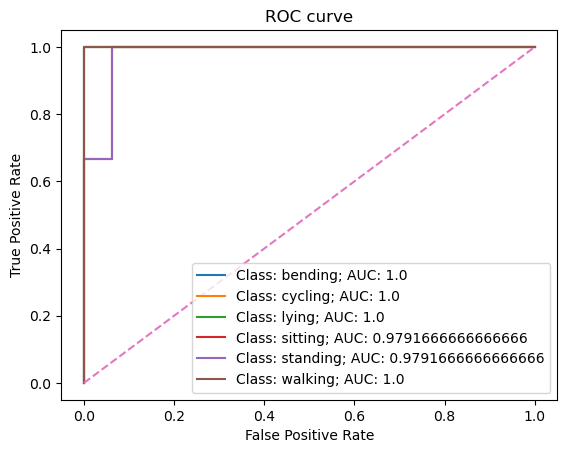

Test accuracy:  0.9473684210526315
Test error:  0.052631578947368474


[0.8417582417582418, 0.9473684210526315]

In [55]:
print(f"Best l value = {val_l}. \nBest training accuracy = {train_acc}\n")
print(f"testing data with l = {val_l}\n")

gaussian(train_data, test_data, val_l, "gaussian", True)

In [56]:
global train_acc
train_acc = 0
global val_l
val_l = 1
res = []
for l in range(1, 21):
    
    res.append(gaussian(train_data, test_data, l,  "multinomial", False))

    if res[-1][1] > train_acc:
        train_acc = res[-1][1]
        val_l = l

result_df = pd.DataFrame(res, columns=['l-value', 'training score', 'training error'])
result_df

l-value  training score  training error
0         1        0.754945        0.245055
1         2        0.798901        0.201099
2         3        0.741758        0.258242
3         4        0.770330        0.229670
4         5        0.814286        0.185714
5         6        0.771429        0.228571
6         7        0.785714        0.214286
7         8        0.727473        0.272527
8         9        0.800000        0.200000
9        10        0.771429        0.228571
10       11        0.756044        0.243956
11       12        0.728571        0.271429
12       13        0.727473        0.272527
13       14        0.728571        0.271429
14       15        0.757143        0.242857
15       16        0.713187        0.286813
16       17        0.697802        0.302198
17       18        0.741758        0.258242
18       19        0.728571        0.271429
19       20        0.741758        0.258242

Best l value = 5. 
Best training accuracy = 0.8142857142857143

testing data with l = 5

Confusion matrix for test data:
[[3 0 0 0 1 0]
 [0 3 0 0 0 0]
 [0 0 2 1 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]

ROC Curve for Training Data


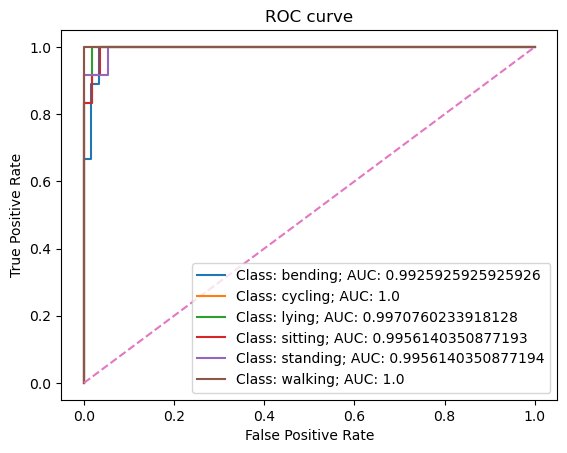


ROC Curve for Testing Data


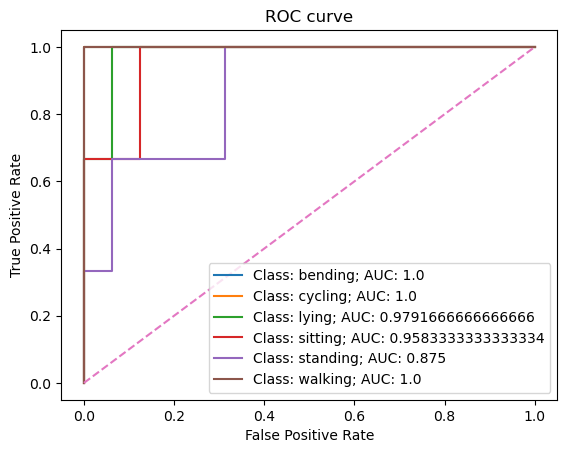

Test accuracy:  0.7894736842105263
Test error:  0.21052631578947367


[0.8142857142857143, 0.7894736842105263]

In [57]:
print(f"Best l value = {val_l}. \nBest training accuracy = {train_acc}\n")
print(f"testing data with l = {val_l}\n")

gaussian(train_data, test_data, val_l, "multinomial", True)

#### ii. Comparison

Looking at the AUC of the Gaussian and Multinomial priors on testing data, we can say that Multinomial priors has less AUC than Gaussian. Naive Bayes’ classifier using Gaussian has the lowest test error. Hence, the Naive Bayes’ classifier using Gaussian priors works better for this multi-classification problem because the larger the AUC the better the classifier.

#### iii. Which method is better for multi-class classification in this problem?


Looking at the AUC of the ROC curves of the testing data for the L1- penalized multinomial regression model, Naive Bayes’ classifier using Gaussian, and Multinomial priors we can see that the AUC of the Naive Bayes’ classifier using Gaussian priors is the highest compared to the other two. The larger the AUC the better the classifier. It also has the lowest test error. Hence, the Naive Bayes’ classifier using Gaussian priors works better for multi-class classification as compared to the other two in this problem.